For writing the narrative and exporting data.

In [8]:
import pickle
import math
import json
import numpy as np
import matplotlib.pyplot as plt

CUNAME = 'Columbia University in the City of New York'
S_TOTALS = pickle.load(open('../data/S_Sex_Graduates.p', 'rb'))
E_TOTALS = pickle.load(open('../data/E_Sex_Graduates.p', 'rb'))
D_TOTALS = pickle.load(open('../data/SE-Detailed_Sex.p', 'rb'))

years = sorted(S_TOTALS.keys())
institutions = sorted(S_TOTALS[ max(years) ].keys())
fields = {
    'Science': set(),
    'Engineering': set()
}
for year in years:
    inst_stats = D_TOTALS[year]['Columbia University in the City of New York']
    for seh in inst_stats.keys():
        for field in inst_stats[seh].keys():
            fields[seh].add(field)
fields['Science'] = sorted(fields['Science'])
fields['Engineering'] = sorted(fields['Engineering'])

print(f'{len(institutions)} institutions, {len(fields["Science"]) + len(fields["Engineering"])} fields.')

11 institutions, 39 fields.


In [13]:
# Returns female and male headcounts for a field in an institution
def get_counts(seh, field, inst='Columbia University in the City of New York', default=None):
    females = []
    males = []
    for year in years:
        stats = D_TOTALS[year][inst][seh].get(field, None)
        if stats is None:
            females.append(default)
            males.append(default)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males

complete_fields = {
    'Science': [],
    'Engineering': [],
}
topic_lookup = {}
for topic in complete_fields.keys():
    for field in fields[topic]:
        females, males = get_counts(topic, field)
        if None not in females and None not in males:
            complete_fields[topic].append(field)
        topic_lookup[field] = topic
print(f'{len(complete_fields["Science"]) + len(complete_fields["Engineering"])} complete fields.')

19 complete fields.


In [41]:
# Convenient function for making subplots
def subplots(num=1, cols=3, figsize=6):
    if num < cols:
        cols = num
    rows = math.ceil(num / cols)
    return plt.subplots(rows, cols, figsize=(figsize * cols, figsize * rows))

# Gets female and male headcounts for a field in an institution
def get_counts(field, inst='Columbia University in the City of New York'):
    females = []
    males = []
    topic = topic_lookup[field]
    for year in years:
        stats = D_TOTALS[year][inst][topic].get(field, None)
        if stats is None:
            females.append(None)
            males.append(None)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males

# Gets proportions for a field
def get_proportions(field, inst='Columbmia University in the City of New York'):
    females, males = get_counts(field, inst)
    proportions = []
    for i in range(len(years)):
        f, m = females[i], males[i]
        if f is None or m is None: 
            proportions.append(None)
        else:
            proportions.append(f / (m+f))
    return proportions

# Gets total populations for a field
def get_total_counts(field, inst='Columbia University in the City of New York'):
    females, males = get_counts(field, inst)
    return [f + m for f, m in zip(females, males)]

# Plots proportions for a field
def plot_proportions(ax, field, inst='Columbia University in the City of New York', title=None, peers=False,
                     start=1994, label_line=True):
    proportions = get_proportions(field, inst)
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_proportions(field, inst), color='lightgreen', linewidth=1)
    start_i = start - years[0]
    # ax.plot(years[:start_i + 1], proportions[:start_i + 1], color='lightgreen')
    ax.plot(years[start_i:], proportions[start_i:], color='green')
    if label_line: ax.annotate(field, (years[start_i], proportions[start_i]))
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(title or field)

x_ticks = [1994 + 4*i for i in range(6)]
# Plots female and male headcounts for a field
def plot_counts(ax, field, inst='Columbia University in the City of New York', title=None):
    females, males = get_counts(field, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=years[0], right=years[-1])
    ax.set_title(title or field)
    ax.set_ylabel('Number of people')
    ax.set_xticks(x_ticks)
    ax.grid()

# Plots triplet for a field
def plot_pair(ax_ary, index, field):    
    if index == None:
        axs = [ax_ary[i] for i in range(2)]
    else:
        axs = [ax_ary[index, i] for i in range(2)]
    plot_proportions(axs[0], field, peers=True)
    plot_counts(axs[1], field)

# Plots triplet for multiple fields
def plot_selected_pairs(selected_fields):
    num_fields = len(selected_fields)
    _, ax = subplots(num_fields*2, cols=2)
    if num_fields == 1:
        plot_pairs(ax, None, selected_fields[0])
        return
    for i, field in enumerate(selected_fields):
        plot_pairs(ax, i, field)

# Gets overall counts from complete fields for an institution in a topic
def get_overall_counts(topic, inst='Columbia University in the City of New York'):
    overallF = [0 for _ in range(len(years))]
    overallM = [0 for _ in range(len(years))]
    counts = {field: get_counts(field, inst, default=0) for field in complete_fields[topic]}

    for field in complete_fields[topic]:
        f, m = counts[field]
        for i in range(len(years)):
            overallF[i] += f[i]
            overallM[i] += m[i]
    return overallF, overallM

# Gets overall proportions from overall counts
def get_overall_proportions(topic, inst='Columbia University in the City of New York'):
    overallF, overallM = get_overall_counts(topic, inst)
    return [0 if m+f == 0 else f/(m+f) for f, m in zip(overallF, overallM)]

# Plots proportions for a topic
def plot_topic_proportions(ax, topic, peers=False, title=None, label=[]):
    colors = ['blue', 'lightblue']
    if topic == 'Science':
        colors = ['red', 'pink']
    if peers:
        for inst in institutions:
            if inst != CUNAME:
                ax.plot(years, get_overall_proportions(topic, inst), color=colors[1], linewidth=1)
    cu_props = get_overall_proportions(topic, CUNAME)
    ax.plot(years, cu_props, color=colors[0], linewidth=2)
    for i in [0, -1] + [year - years[0] for year in label]:
        ax.annotate("{0:.0%}".format(cu_props[i]), (years[i], cu_props[i]))
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(title or topic)

# Plots a female and male headcounts for a topic
def plot_topic_counts(ax, topic, inst='Columbia University in the City of New York', title=None):
    females, males = get_overall_counts(topic, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(title or topic)
    ax.set_ylabel('Number of people')

In [30]:
def plot_topic_fields(topic):
    selected = fields[topic]
    num_cols = 5
    _, ax_arr = subplots(len(selected), cols=num_cols)
    for i, field in enumerate(selected):
        plot_counts(ax_arr[i // num_cols, i % num_cols], field)

# Engineering

Notes:
* According to the [post-2010 mapping of instructional programs to GSS fields](https://ncsesdata.nsf.gov/gradpostdoc/2016/html/GSS2016_TTA_16.html), Earth and Environmental Engineering is grouped into Civil Engineering. The New York Post has it that Columbia [replaced its mining engineering program](https://nypost.com/2013/08/25/magnates-missing-millions-columbia-university-mining-program-runs-dry/) with Earth and Environmental Engineering. This matches the disappearance of Mining Engineering data after 1999. Moreover, in [SEAS' past bulletins (available since 2005)](https://bulletin.engineering.columbia.edu/previous-years-bulletins), Mining Engineering and Earth and Environmental Engineering are the two and only fields given the [HEGIS code](http://www.nysed.gov/college-university-evaluation/new-york-state-taxonomy-academic-programs-hegis-codes) 918.
* According to [NYS HEGIS codes](http://www.nysed.gov/college-university-evaluation/new-york-state-taxonomy-academic-programs-hegis-codes) and the [latest SEAS bulletin](https://bulletin.engineering.columbia.edu/files/seasbulletin/bulletin2012-2013.pdf) with registered programs and HEGIS codes (2012-13): the Engineering nec fields are "Combined Plan w/Affiliated College; Dual B.S. (M.S.)/B.A." and Computer Engineering. But GSS classifies Computer Engineering as Electrical Engineering. We will consider Engineering nec to be 0 before 2014.
* Biomedical engineering was established in [2000](https://bme.columbia.edu/about-0), so it can be zero-ed before 2001.

Takeaways: Engineering nec can be considered 0 before 2014, Mining Engineering after 1999, annd Biomedical Engineering before 2001. That leaves Chemical Engineering and Civil Engineering to be imputed.

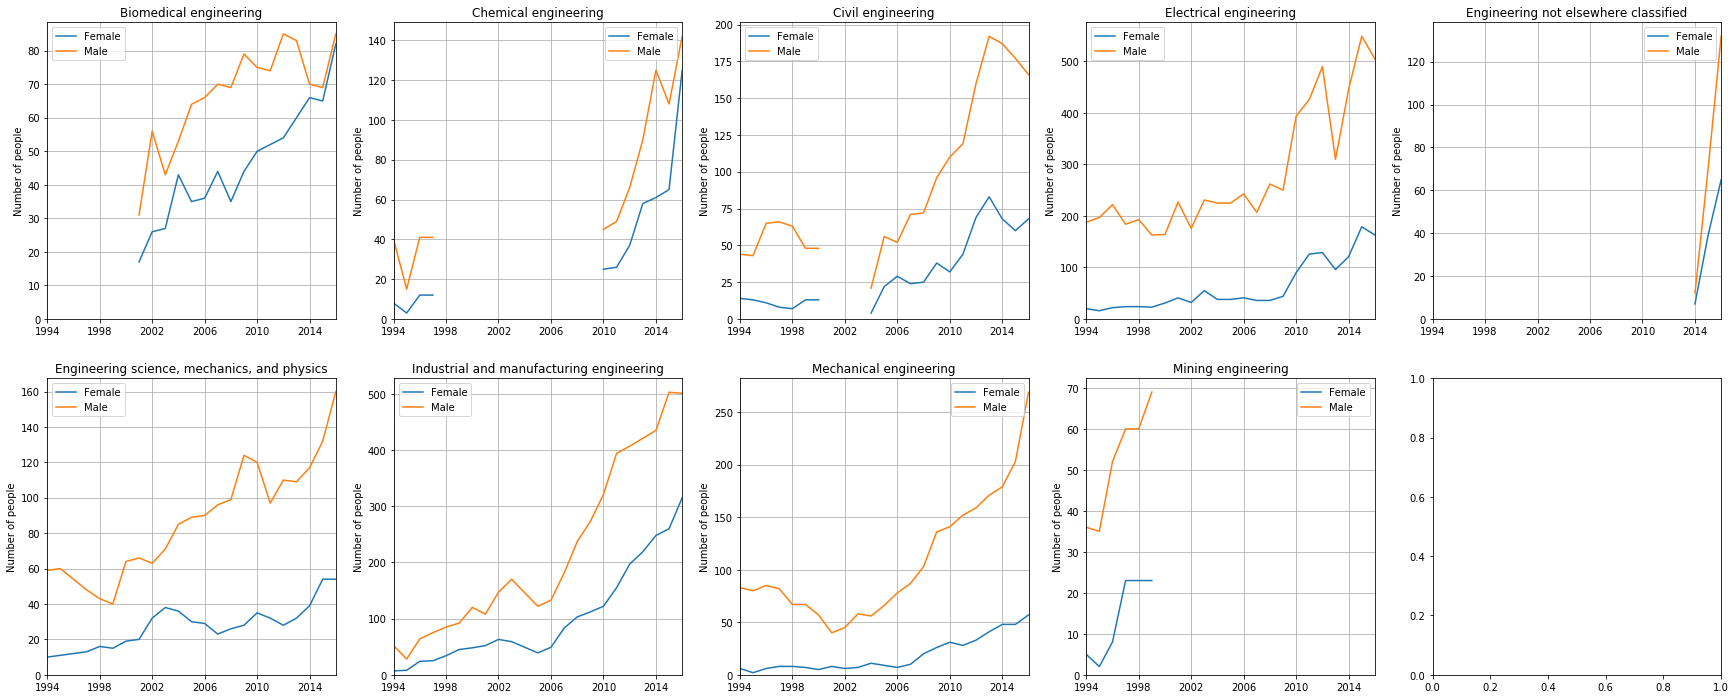

In [42]:
plot_topic_fields('Engineering')